In [1]:
import numpy as np
from scipy.optimize import curve_fit

In [2]:
# For data visualization
from matplotlib import pyplot as plt

#### Section 1_Finding the homography matrix

In [17]:
# Value function
def VAL(dataX, *h):
    
    n = dataX.shape[0]//2  # get the number of input points
    X = dataX[:n]
    Y = np.zeros(2*n) #create a ne factor of length 2n
    h0, h1, h2, h3, h4, h5, h6, h7, h8 = h
    x = X[:, 0]
    y = X[:, 1]
    w = h6*x+h7*y+h8
    u = (h0*x+h1*y+h2)/w
    v = (h3*x+h4*y+h5)/w
    Y[:n] = u
    Y[n:] = v
    
    return Y

In [25]:
# Jacobian matrix
def Jac(dataX, *h):
    
    h0, h1, h2, h3, h4, h5, h6, h7, h8 = h
    n = dataX.shape[0]//2
    X = dataX[:n]
    J = np.zeros((2*n, 9))
    x = X[:, 0]
    y = X[:, 1]
    w = h6*x+h7*y+h8
    sx = (h0*x+h1*y+h2)
    sy = (h3*x+h4*y+h5)
    J[:n, :3] = np.array([x/w, y/x, 1/w]).T
    J[:n, 6:] = np.array([-sx*x/w**2, -sx*y/w**2, -sx/w**2]).T
    J[n:, 3:] = np.array([x/w, y/w, 1/w, -sy*x/w**2, -sy*y/w**2, -sy/w**2]).T
    
    return J


In [5]:
# ground truth matrix
sample_H = np.random.rand(3,3)
sample_H = (sample_H - .5) * 15
sample_H

array([[-7.05018219,  1.12583832,  0.82308613],
       [ 1.49382461, -3.29137072, -5.59846767],
       [ 2.92648262,  4.74322243, -5.01959039]])

In [64]:
# Generate 50 independent data points Xi=(xi, yi, 1)
X = (np.random.rand(50, 3) -.5) * 10
X[:, -1] = 1
# Generate 50 'observed' dependent data points Yi=(u_i, v_i) 
Y_observed = (np.dot(sample_H, X.T)).T
Y_observed = Y_observed[:, :2]/Y_observed[:, [-1]] 
# Format Y_absorved as a vector (u_X1, u_X2,..., u_X50, v_X1, v_X2,..., v_X50) and add some noise to it
Y_observed = np.ravel(Y_observed, order='F')+np.random.normal(0, 1, 100)


In [65]:
# Set the initial parameter
init_h = np.ravel(sample_H)+np.random.normal(0, 0.01, 9)
# Each independent data point maps to 2 dependent values (u_Xi, v_Xi),
# Stacking inputX makes the model look like one to one mapping
inputX = np.vstack((X[:,:2],X[:,:2]))
# Perform LM_algorithm
popt, pcov = curve_fit(VAL, inputX, Y_observed, p0=init_h, method='lm', jac=Jac)

In [66]:
# The parameters found
popt

array([-6.04604995,  0.87405252, -0.18655843,  1.37956138, -2.47300873,
       -4.82005716,  2.60713867,  4.22040085, -4.47363446])

In [67]:
# The covariance matrix for the parameters found
pcov

array([[ 2.28117409e+01, -2.57124450e-02, -2.41796001e+00,
        -4.77337171e+00,  8.53249319e+00,  1.66395713e+01,
        -9.07130810e+00, -1.46829192e+01,  1.55672968e+01],
       [-2.57124450e-02,  5.06738923e-04,  2.55501330e-03,
         5.36989312e-03, -9.59356014e-03, -1.86931949e-02,
         1.02043716e-02,  1.65163461e-02, -1.75102200e-02],
       [-2.41796001e+00,  2.55501330e-03,  5.36148871e-01,
         5.12705239e-01, -9.27767998e-01, -1.82054009e+00,
         9.60967709e-01,  1.55636510e+00, -1.65001157e+00],
       [-4.77337171e+00,  5.36989312e-03,  5.12705239e-01,
         1.14192755e+00, -1.55835488e+00, -3.73618481e+00,
         1.89869290e+00,  3.07326554e+00, -3.25839770e+00],
       [ 8.53249319e+00, -9.59356014e-03, -9.27767998e-01,
        -1.55835488e+00,  3.56154454e+00,  5.82733849e+00,
        -3.39273456e+00, -5.49161247e+00,  5.82233120e+00],
       [ 1.66395713e+01, -1.86931949e-02, -1.82054009e+00,
        -3.73618481e+00,  5.82733849e+00,  1.260824

In [68]:
# The standard deviation errors of the parameters found
perr = np.sqrt(np.diag(pcov))
perr

array([4.77616383, 0.02251086, 0.73222187, 1.0686101 , 1.88720548,
       3.55080888, 1.90045298, 3.07606252, 3.26149954])

In [69]:
# Generate Y with parameters found
z = VAL(inputX, -6.04604995,  0.87405252, -0.18655843,  1.37956138, -2.47300873,
       -4.82005716,  2.60713867,  4.22040085, -4.47363446)

In [70]:
# Ground truth Y 
y = VAL(inputX, -7.05018219,  1.12583832,  0.82308613,
       1.49382461, -3.29137072, -5.59846767,
       2.92648262,  4.74322243, -5.01959039)

<function matplotlib.pyplot.show(close=None, block=None)>

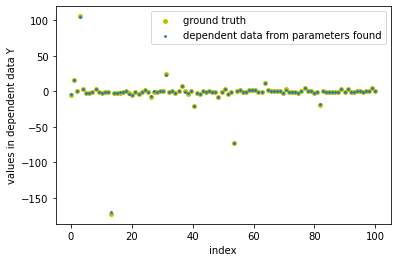

In [71]:
# Plot the ground truth and the dependent data generated with parameters found in sequence
r = np.linspace(0, 100, 100)
plt.figure(0)
plt.scatter(r, y ,s=15, c='y', label='ground truth')
plt.scatter(r, z, s=3, label='dependent data from parameters found')
plt.legend()
plt.xlabel('index')
plt.ylabel('values in dependent data Y')
plt.show

#### Section2_Finding parameters for an Exponential function

In [72]:
# ground truth parameter
a1, b1, c1 = 2.1, 1, 3.5
# generate 100 independent data x
x = np.random.rand(100,)
# generate the 'observed' data y with noise
y = [np.exp(a1*i**2+b1*i+c1)+random.gauss(0,4) for i in x]

In [73]:
# Value function
def VAL(dataX, *h):
    a, b, c = h
    return np.exp(a*dataX**2+b*dataX+c)

In [74]:
# Jacobian matrix
def Jac(dataX, *h):
    a, b, c = h
    n = len(dataX)
    J = np.zeros((n, 3))
    # partial derivative with respect to a
    J[:, 0] = np.exp(a*dataX**2+b*dataX+c)*dataX**2
    # partial derivative with respect to b
    J[:, 1] = np.exp(a*dataX**2+b*dataX+c)*dataX
    # partial derivative with respect to c
    J[:, 2] = np.exp(a*dataX**2+b*dataX+c)
    
    return J

In [75]:
# Set the initial parameters
init_h = np.random.rand(3) * 10
# Perform LM_algorithm
popt, pcov = curve_fit(VAL, x, y, p0=init_h, method='lm', jac=Jac)

In [76]:
# Parameters found
popt

array([2.03204003, 1.11106133, 3.45599143])

In [77]:
# The standard deviation errors of the parameters found
perr = np.sqrt(np.diag(pcov))
perr

array([0.04498819, 0.06657303, 0.02428414])

In [211]:
r = np.linspace(0, 1, 100)
# Ground truth
z = VAL(r, 2.1, 1, 3.5)
# Curve found
z_ = VAL(r, 2.12237705, 0.97269473, 3.51029404)

<function matplotlib.pyplot.show(close=None, block=None)>

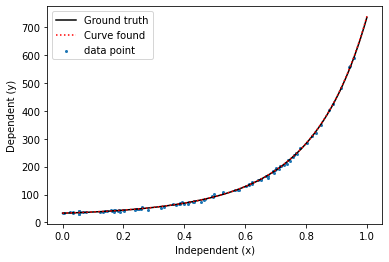

In [227]:
# Plot the ground truth curve and curve found from the observed data
plt.figure(0)
plt.scatter(x, y, s=4, label='data point')
plt.plot(r, z, 'k', label='Ground truth')
plt.plot(r, z_, ':r', label='Curve found')
plt.xlabel('Independent (x)')
plt.ylabel('Dependent (y)')
plt.legend()
plt.show

In [228]:
plt.plot?